### Problem statement: 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data and Importing all the important libraries

In [60]:
import warnings 
warnings.filterwarnings("ignore")

import pathlib
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import load_img
from tqdm import tqdm

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [8]:
# Defining the path for train and test images

data_dir_train = pathlib.Path(r"C:\Users\sprag\Documents\PG-AIML\CNN_assignment\dataset\Train")
data_dir_test = pathlib.Path(r"C:\Users\sprag\Documents\PG-AIML\CNN_assignment\dataset\Test")

In [9]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("No of images in given train dataset: " + str(image_count_train))
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("No of images in given test dataset: " + str(image_count_test))

No of images in given train dataset: 2239
No of images in given test dataset: 118


In [10]:
# Removing corrupted Images and resizing
newsize = (180, 180)
for i in tqdm(list(data_dir_test.glob('*/*.jpg'))):
    try:
        im = Image.open(i)
        im = im.resize(newsize)
    except:
        continue
    new_path = str(i).replace('Test', 'Test-conv').replace('.jpg','.jpeg')
    if not os.path.exists(Path(new_path).parent): 
        os.makedirs(Path(new_path).parent)
    im.save(new_path)

100%|███████████████████████████████████████████████████████████████████| 118/118 [00:06<00:00, 18.63it/s]


In [11]:
data_dir_train = pathlib.Path(r"C:\Users\sprag\Documents\PG-AIML\CNN_assignment\dataset\Train-conv")
data_dir_test = pathlib.Path(r"C:\Users\sprag\Documents\PG-AIML\CNN_assignment\dataset\Test-conv")

In [13]:
image_count_train = len(list(data_dir_train.glob('*/*.jpeg')))
print("No of images in train dataset: " + str(image_count_train))
image_count_test = len(list(data_dir_test.glob('*/*.jpeg')))
print("No of images in test dataset: " + str(image_count_test))

No of images in train dataset: 2152
No of images in test dataset: 118


### Data Visualization

In [14]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

Found 2152 files belonging to 9 classes.


In [15]:
#get classes of Skin Cancer
class_names = train_ds.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [16]:
#Dictionary to store the path of image as per the class
files_path_dict = {}
for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

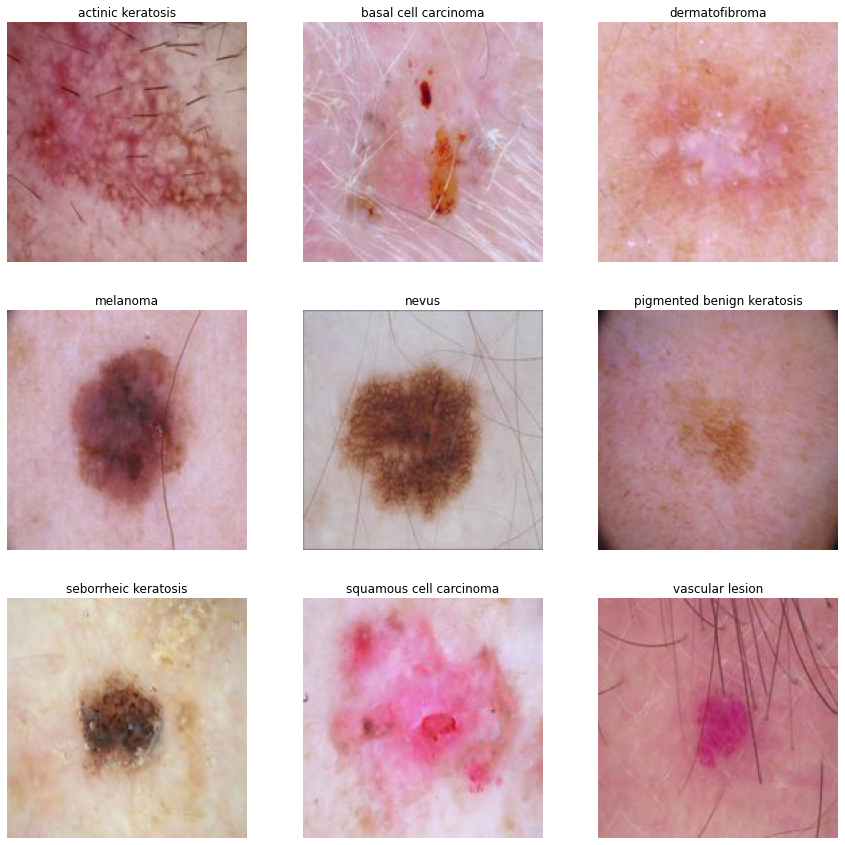

In [17]:
#Visualize each type of disease 
plt.figure(figsize=(15,15))
i = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    i += 1
    plt.subplot(3,3,i)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [18]:
#count number of image in each classes in train
count= []
for path in pathlib.Path(data_dir_train).iterdir():
    if path.is_dir():
        count.append(len([name for name in os.listdir(path) 
                        if os.path.isfile(os.path.join(path, name))]))
        
#name of the classes
sub_directory = [name for name in os.listdir(data_dir_train)
                if os.path.isdir(os.path.join(data_dir_train, name))]
    
#dataframe with image count and class.
df = pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

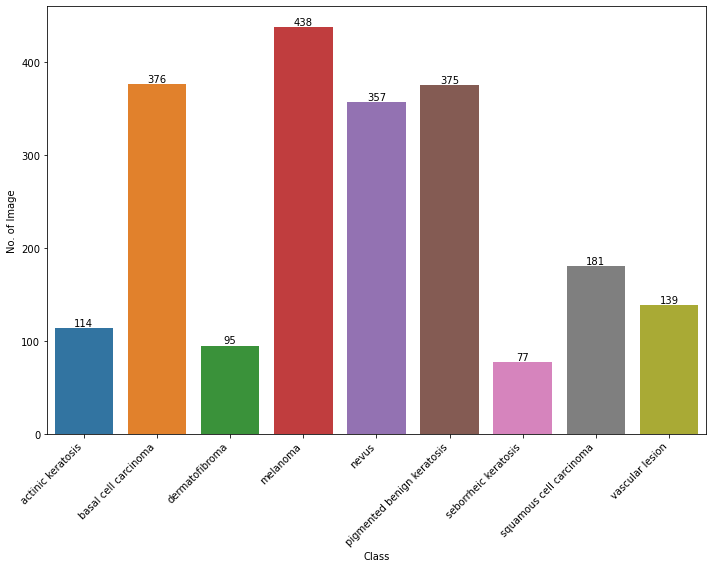

In [19]:
plt.figure(figsize=(10, 8))
ax = sns.barplot(y="No. of Image", x="Class", data=df)
for i in ax.containers:
    ax.bar_label(i,)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [20]:
val_ds=tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

Found 118 files belonging to 9 classes.


In [21]:
#count number of image in each classes in test folder
count= []
for path in pathlib.Path(data_dir_test).iterdir():
    if path.is_dir():
        count.append(len([name for name in os.listdir(path) 
                        if os.path.isfile(os.path.join(path, name))]))
        
#name of the classes
sub_directory = [name for name in os.listdir(data_dir_test)
                if os.path.isdir(os.path.join(data_dir_test, name))]
    
#dataframe with image count and class.
df_test = pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])
df_test

,Class,No. of Image
0,actinic keratosis,16
1,basal cell carcinoma,16
2,dermatofibroma,16
3,melanoma,16
4,nevus,16
5,pigmented benign keratosis,16
6,seborrheic keratosis,3
7,squamous cell carcinoma,16
8,vascular lesion,3


In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

Model 1: 3 convulution layer

In [30]:
#CNN model 1:

#Sequential allows you to add layer-by-layer  
model = Sequential()

#Rescaling
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   

#First Convulation
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten
model.add(layers.Flatten())

#Dense with relu activation
model.add(layers.Dense(128,activation='relu'))

#Dense with softmax activation
model.add(layers.Dense(len(class_names),activation='softmax'))

In [31]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 41, 41, 128)      

##### Adam optimization: 
    It is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
##### Categorical_crossentropy: 
    Used as a loss function for multi-class classification model where there are two or more output labels.


In [32]:
#Compile the Model
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [33]:
epochs = 20
history = model.fit(train_ds, validation_data = val_ds, epochs=epochs)

Epoch 1/20
68/68 [==============================] - 29s 424ms/step - loss: 1.9064 - accuracy: 0.3039 - val_loss: 2.3415 - val_accuracy: 0.3136
Epoch 2/20
68/68 [==============================] - 30s 435ms/step - loss: 1.6105 - accuracy: 0.4229 - val_loss: 2.3164 - val_accuracy: 0.2966
Epoch 3/20
68/68 [==============================] - 30s 442ms/step - loss: 1.4550 - accuracy: 0.4926 - val_loss: 2.2703 - val_accuracy: 0.3390
Epoch 4/20
68/68 [==============================] - 31s 451ms/step - loss: 1.3942 - accuracy: 0.5158 - val_loss: 2.1240 - val_accuracy: 0.3559
Epoch 5/20
68/68 [==============================] - 31s 451ms/step - loss: 1.2700 - accuracy: 0.5539 - val_loss: 2.2127 - val_accuracy: 0.3136
Epoch 6/20
68/68 [==============================] - 31s 459ms/step - loss: 1.2493 - accuracy: 0.5576 - val_loss: 2.1887 - val_accuracy: 0.3559
Epoch 7/20
68/68 [==============================] - 31s 460ms/step - loss: 1.1769 - accuracy: 0.5692 - val_loss: 2.6987 - val_accuracy: 0.3136

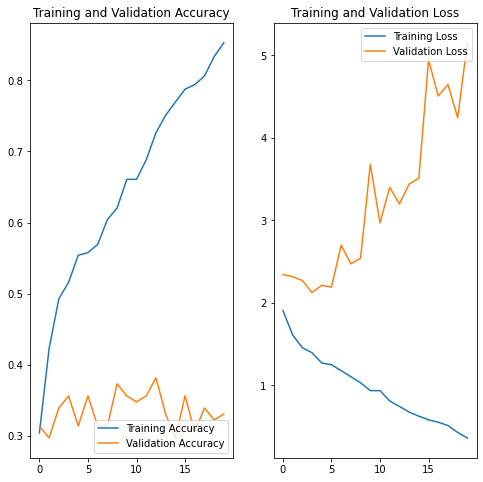

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
#CNN model 2 with dropouts: increase epochs to 50

model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   

model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Dropout(0.5))

model.add(layers.Flatten())

model.add(layers.Dense(128,activation='relu'))

model.add(layers.Dropout(0.25))

model.add(layers.Dense(len(class_names),activation='softmax'))

In [43]:
#Compile the Model
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [44]:
# View the summary of all layers
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 41, 41, 128)      

In [45]:
epochs = 50
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/50
68/68 [==============================] - 31s 445ms/step - loss: 2.0197 - accuracy: 0.2351 - val_loss: 2.2943 - val_accuracy: 0.2373
Epoch 2/50
68/68 [==============================] - 31s 455ms/step - loss: 1.7488 - accuracy: 0.3657 - val_loss: 2.1699 - val_accuracy: 0.2881
Epoch 3/50
68/68 [==============================] - 31s 454ms/step - loss: 1.5308 - accuracy: 0.4726 - val_loss: 2.5607 - val_accuracy: 0.2458
Epoch 4/50
68/68 [==============================] - 31s 451ms/step - loss: 1.4403 - accuracy: 0.4902 - val_loss: 2.3785 - val_accuracy: 0.3559
Epoch 5/50
68/68 [==============================] - 32s 469ms/step - loss: 1.3687 - accuracy: 0.5246 - val_loss: 2.1294 - val_accuracy: 0.3305
Epoch 6/50
68/68 [==============================] - 33s 482ms/step - loss: 1.3008 - accuracy: 0.5367 - val_loss: 2.8161 - val_accuracy: 0.3051
Epoch 7/50
68/68 [==============================] - 33s 487ms/step - loss: 1.2992 - accuracy: 0.5358 - val_loss: 2.0959 - val_accuracy: 0.3983

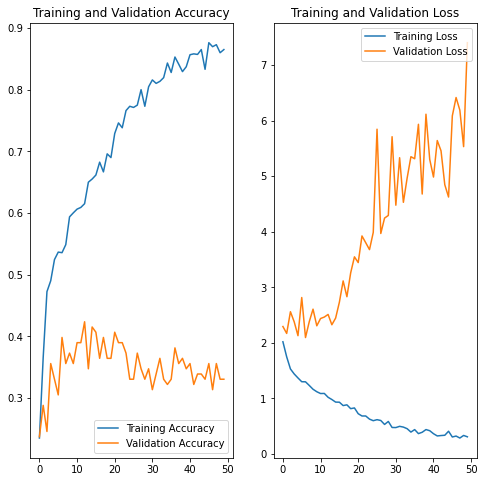

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Augmenting images to improve the dataset size. Adding 500 samples per class

In [37]:
path_to_training_dataset="C:/Users/sprag/Documents/PG-AIML/CNN_assignment/dataset/Train-conv/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to C:/Users/sprag/Documents/PG-AIML/CNN_assignment/dataset/Train-conv/actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=180x180 at 0x2C74A3DCCA0>: 100%|█| 500/5


Initialised with 376 image(s) found.
Output directory set to C:/Users/sprag/Documents/PG-AIML/CNN_assignment/dataset/Train-conv/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x2C74A3CF400>: 100%|█| 500/500 [00:00<00:00, 8


Initialised with 95 image(s) found.
Output directory set to C:/Users/sprag/Documents/PG-AIML/CNN_assignment/dataset/Train-conv/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x2C74A3FA3D0>: 100%|█| 500/500 [00:00<00:00, 7


Initialised with 438 image(s) found.
Output directory set to C:/Users/sprag/Documents/PG-AIML/CNN_assignment/dataset/Train-conv/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x2C74A385D00>: 100%|█| 500/500 [00:00<00:00, 7


Initialised with 357 image(s) found.
Output directory set to C:/Users/sprag/Documents/PG-AIML/CNN_assignment/dataset/Train-conv/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x2C74A4466A0>: 100%|█| 500/500 [00:00<00:00, 7


Initialised with 375 image(s) found.
Output directory set to C:/Users/sprag/Documents/PG-AIML/CNN_assignment/dataset/Train-conv/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x2C74A3EC100>: 100%|█| 500/500 [00:00<00:00, 7


Initialised with 77 image(s) found.
Output directory set to C:/Users/sprag/Documents/PG-AIML/CNN_assignment/dataset/Train-conv/seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=180x180 at 0x2C74A385CA0>: 100%|█| 500/5


Initialised with 181 image(s) found.
Output directory set to C:/Users/sprag/Documents/PG-AIML/CNN_assignment/dataset/Train-conv/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x2C74A48AD90>: 100%|█| 500/500 [00:00<00:00, 7


Initialised with 139 image(s) found.
Output directory set to C:/Users/sprag/Documents/PG-AIML/CNN_assignment/dataset/Train-conv/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x2C74A3D4CD0>: 100%|█| 500/500 [00:00<00:00, 7


In [52]:
# check counts after augmenting images
image_count_train = len(list(data_dir_train.glob('*/*.jpeg')))
print("No of images in train dataset after augmentation: " + str(image_count_train))
image_count_test = len(list(data_dir_test.glob('*/*.jpeg')))
print("No of images in test dataset: " + str(image_count_test))

No of images in train dataset after augmentation: 6652
No of images in test dataset: 118


In [54]:
# train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 6652 files belonging to 9 classes.
Using 5322 files for training.


In [55]:
# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6652 files belonging to 9 classes.
Using 1330 files for validation.


In [56]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [57]:
#CNN Model 3 : After augmentation

model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   

model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Dropout(0.5))

model.add(layers.Flatten())

model.add(layers.Dense(128,activation='relu'))

model.add(layers.Dropout(0.25))

model.add(layers.Dense(len(class_names),activation='softmax'))


In [58]:
#Compile the Model
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [61]:
#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

In [62]:
#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [64]:
# Train the model
epochs = 50
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/50
167/167 [==============================] - ETA: 0s - loss: 0.4926 - accuracy: 0.8183
Epoch 1: val_accuracy improved from 0.77444 to 0.77669, saving model to model.h5
167/167 [==============================] - 85s 512ms/step - loss: 0.4926 - accuracy: 0.8183 - val_loss: 0.7736 - val_accuracy: 0.7767
Epoch 2/50
167/167 [==============================] - ETA: 0s - loss: 0.4452 - accuracy: 0.8388
Epoch 2: val_accuracy improved from 0.77669 to 0.79173, saving model to model.h5
167/167 [==============================] - 84s 501ms/step - loss: 0.4452 - accuracy: 0.8388 - val_loss: 0.7644 - val_accuracy: 0.7917
Epoch 3/50
167/167 [==============================] - ETA: 0s - loss: 0.4021 - accuracy: 0.8455
Epoch 3: val_accuracy improved from 0.79173 to 0.79624, saving model to model.h5
167/167 [==============================] - 85s 507ms/step - loss: 0.4021 - accuracy: 0.8455 - val_loss: 0.8056 - val_accuracy: 0.7962
Epoch 4/50
167/167 [==============================] - ETA: 0s - los

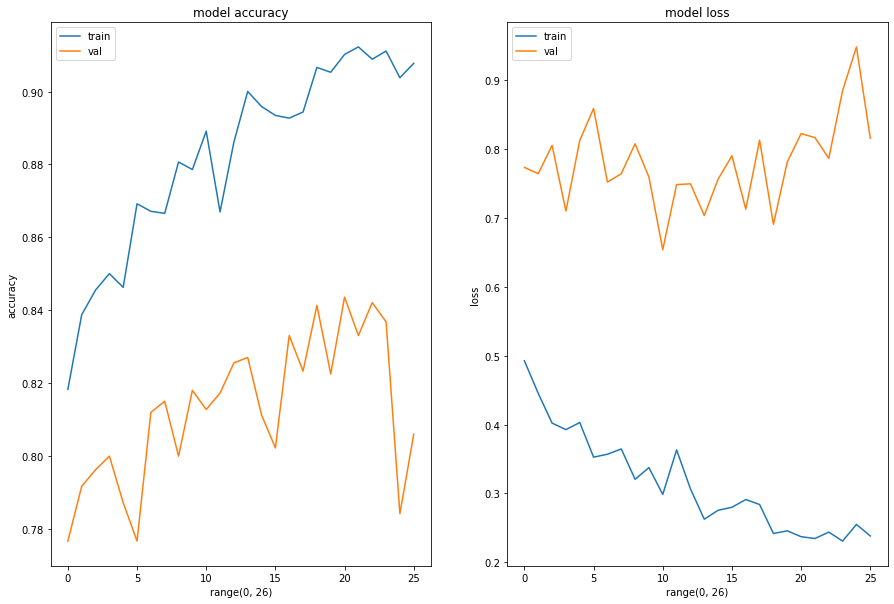

In [67]:
# Visualizing the results
epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Model Prediction

1/1 [==============================] - 0s 29ms/step
Actual Class : basal cell carcinoma
Predictive Class : basal cell carcinoma


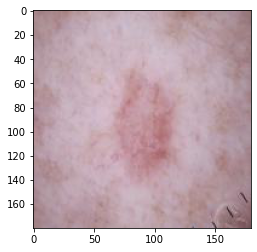

In [85]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[2], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class : "+ class_names[1] +'\n'+ "Predictive Class : "+pred_class )

<li>Accuracy on training data has increased by using Augmentor library</li>
<li>Model is still overfitting</li>
<li>The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.</li>
<li>The Model can be further improved by tuning the hyperparameter</li>